Distribution Statement A. Approved for public release: distribution is unlimited.

Numerical Laboratory for K-12 to Learn and Practice Measuring and Modeling Ferromagnetic Resonant Materials (ISEC 2025 Conference Paper)

LABRATORY MODULE: Riley Frevert, Anna Keffer, Miram Elag, and Dr. Michael Sherburne - Updated (1/21/2025)

Time Requirements: 
    - 30-90 minutes (module will ideally be completed within one class period)
    - Prep time: 15-30 minutes for installation of all necessary programs
    - 90 minutes for completion of module and assessment questions

Prerequisite concepts: 
    -Elementary programming comprehension
    -Proficient undertanding of magnetic
    -Mastery of electron behavior and properties
    -Fundamental knowledge of relationship between how electrons behave and magnetic fields

Essential Question: 
    -How can VNA-FMR measurements be used to properly model magnetic nanocrystal susceptibility?

Materials/Equipment:
    - Student must have Anaconda installed on their device (and if not already accessible, install Jupyter Notebook directly through the Anaconda software)
    - Student must have downloaded all of the necessary code (First Principles, CONTINUE)
    - Student must install Ubermag program through the Anaconda (navigate: {environment --> new folder --> open terminal} and follow the referenced tutorial (https://ubermag.github.io/installation.html)
    - Student must install natsort in their Ubermag environment in Anaconda using the following: conda install -c conda-forge natsort

PROCEDURE:

1. Students install ubermag using the tutorial link above and then run package install:

In [ ]:
# Import Required Libraries
import scipy.io
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc
import numpy as np
import pandas as pd
import os
import natsort
from natsort import natsorted
import math

In [ ]:
## Change the ... to the file location on your computer! ##

# Getting HDC field from Matlab file
FileLocation1 = '.../HdcFields_Final_v2'
FileLocation2 = '.../170.s2p'
FileLocation3 = '.../Control'
FileLocation4 = ".../Control/"
FileLocation5 = '.../170.s2p'
FileLocation6 = '.../Sample'
FileLocation7 = ".../Sample/"
FileLocation8 = '.../ccviridisarray.mat'

HDC = scipy.io.loadmat(FileLocation1) 
HDC = HDC.get("HdcFields")

# Function that converts db/degrees to intensity of suceptibility - like rfparam in matlab but a little different
def Conversion(Mag, Angle):
    r = np.power(10, (Mag/20)) #S21 Mag
    x = np.multiply(r, (np.cos(np.radians(Angle)))) #S21 Angle - x = r*cos(degrees)
    y = np.multiply(r, (np.sin(np.radians(Angle)))) #S21 Angle - y = r*sin(degrees)
    y = y * 1j
    return x + y

# Reading and titling control data
filename = pd.read_csv(FileLocation2, delimiter=' ', skiprows=7)
filename.columns = ['Freq', 'S11 Mag', 'S11 Angle', 'S21 Mag', 'S21 Angle', 'S12 Mag', 'S12 Angle', 'S22 Mag', 'S22 Angle']
object1 = filename

# Making variable frequencies and S21CCreference
Freq1 = object1["Freq"]
S21CCreference_S5 = Conversion(object1["S21 Mag"], object1["S21 Angle"])

In [ ]:
## Making a table of Control values

# Making a list of each file in control
contents = os.listdir(FileLocation3) # os module part of standard python
allFiles = natsorted(contents)

#Reformatting table to not be in scientific notation
np.set_printoptions(suppress = True)

# Making a starting row - will be deleted later
S21Control_S5ex = np.array(range(0, 10001))

# Making array of the compared S21 values in each file
for i in range(0, 175):
    object = pd.read_csv(FileLocation4 + str(allFiles[i]), delimiter=' ', skiprows=7)
    object.columns = ['Freq', 'S11 Mag', 'S11 Angle', 'S21 Mag', 'S21 Angle', 'S12 Mag', 'S12 Angle', 'S22 Mag', 'S22 Angle']
    
    Freq = object["Freq"]
    S21CC_S5 = Conversion(object["S21 Mag"], object["S21 Angle"])

    # Make new row of compared S21CCs and add to S21Control array
    S21CCdegrees_S5 = 20 * np.log10(S21CC_S5.abs()) # in Matlab, mat2db of abs of each value in S21CC
    S21CCdegrees_reference = 20 * np.log10(S21CCreference_S5.abs()) # in Matlab, mat2db of abs of each value in S21CCreference
    rowtoadd = (S21CCdegrees_S5 - S21CCdegrees_reference)
    S21Control_S5ex = np.vstack ((S21Control_S5ex, rowtoadd) )

# Changing numpy array to pandas table for better access and delete starting row
S21Control_S5ex = pd.DataFrame(S21Control_S5ex)
S21Control_S5 = S21Control_S5ex.drop(S21Control_S5ex.index[0])

In [ ]:
## Making a table of test core values

# Reading and titling file data
filename = pd.read_csv(FileLocation5, delimiter=' ', skiprows=7)
filename.columns = ['Freq', 'S11 Mag', 'S11 Angle', 'S21 Mag', 'S21 Angle', 'S12 Mag', 'S12 Angle', 'S22 Mag', 'S22 Angle']
object = filename

# Making variable frequencies and S21CCreference
Freq = object["Freq"]
S21CCreference_S3 = Conversion(object["S21 Mag"], object["S21 Angle"])

# Making a list of each file in test core
contents = os.listdir(FileLocation6) # os module part of standard python
allFiles = natsorted(contents)

# Making a starting row - will be deleted later
S21Test_S3ex = np.array(range(0, 10001))                                             

# Making array of the compared S21 values in each file
for i in range(0, 175):
    object = pd.read_csv(FileLocation7 + str(allFiles[i]), delimiter=' ', skiprows=7)
    object.columns = ['Freq', 'S11 Mag', 'S11 Angle', 'S21 Mag', 'S21 Angle', 'S12 Mag', 'S12 Angle', 'S22 Mag', 'S22 Angle']
    
    Freq = object["Freq"]
    S21CC_S3 = Conversion(object["S21 Mag"], object["S21 Angle"])

    # Make new row of compared S21CCs and add to S21Control array
    S21CCdegrees_S3 = 20 * np.log10(S21CC_S3.abs())                                # mat2db of abs of each value in S21CC
    S21CCdegrees_ref = 20 * np.log10(S21CCreference_S3.abs())                   # mat2db of abs of each value in S21CCreference
    rowtoadd = (S21CCdegrees_S3 - S21CCdegrees_ref)
    S21Test_S3ex = np.vstack ((S21Test_S3ex, rowtoadd) )

# Changing numpy array to pandas table for better access and delete starting row
S21Test_S3 = np.delete(S21Test_S3ex, 0, 0)
S21Test_S3 = S21Test_S3 - S21Control_S5
#S21Test_S3[S21Test_S3 > 0] = 0
S21Test_S3 = pd.DataFrame(S21Test_S3)

In [ ]:
## Setting up for plot

# Setting X and Y be HDC and frequency with meshgrid
Xst, Yst = np.meshgrid(HDC, Freq)

# Transposing and smoothing S21Control
t_S21Test = S21Test_S3.transpose()                        # Transpose
smd_S21Test = savgol_filter(t_S21Test, 15, 3)             # Smooth
smd_S21Test = pd.DataFrame(smd_S21Test)

## Import ccviridis colormap array
colorarray = scipy.io.loadmat(FileLocation8)
colorarrayext = colorarray['colorarray']
cc_cmap = ListedColormap(colorarrayext)

In [ ]:
## Plotting

plt.rcdefaults()

# Make figure bases
fig = plt.figure()
ax = plt.axes(projection = '3d')

# Converting HDC and frequency into kOe and GHz
X = (np.divide(Xst, 1000))
Y = (np.divide(Yst, 1000000000))

# Choosing colormap and plot
the_plot = ax.plot_surface(X, Y, smd_S21Test, cmap = cc_cmap)

# Labeling Plot
cbr = fig.colorbar(the_plot)
cbr.set_label('$|\Delta S_{21}| (dB)$', fontsize = 13, labelpad = 12)
plt.xlabel('Magnetic Field (kOe)', fontsize = 15, labelpad = 20)
ax.xaxis.set_label_coords(10, -.1)
plt.ylabel('Frequency (GHz)', fontsize = 15, labelpad = 16)

# Adjusting veiw to overhead and hiding grid lines
ax.view_init(90, 270)
ax.grid(False)

# Hide axes ticks
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_zticks([])

plt.show()

In [61]:
# Getting section from sample
newS21 = smd_S21Test.drop(range(7600, 10001)) #columns have names 7600-10001
newS21 = newS21.drop(newS21.columns[range(0, 15)], axis = 1)

# Cutting HDC and frequency arrays to size of data section
HDC2 = pd.DataFrame(HDC)
Freq2 = pd.DataFrame(Freq)
HDC2 = HDC2.drop(HDC2.columns[range(160, 175)], axis = 1)
Freq2 = Freq2.drop(range(7600, 10001))
X2, Y2 = np.meshgrid(HDC2, Freq2)
Y2 = (np.divide(Y2, 1000000000))

In [62]:
# Making frequency column, starting at 1
shifting_row = 40
shifting_row = pd.DataFrame([40])
Freq2Ref = pd.concat([shifting_row, Freq2]).reset_index(drop = True)
Freq2Ref = Freq2Ref.drop(Freq2Ref.columns[0], axis = 1)
Freq2Ref = Freq2Ref.drop(0)

# Making column of row values
RowsRef = [*range(0, 7601)]
RowsRef = pd.DataFrame(RowsRef)

# Adding columns together to make Reference Table
Freq2Ref['Rows'] = RowsRef
RefTable = Freq2Ref
RefTable

# Function that finds certain frequency from row values
def Row2Freq(row_of_maxvalue):
    indexnumber = row_of_maxvalue
    FreqValue = RefTable._get_value(indexnumber, 'Freq') # Gets value at row index under 'Freq'
    return FreqValue

In [63]:
## Making large reference table to show lowest points and their coordinates

# Making starting row and names for reference table, Points
Points = np.array([[1, 2, 3, 4]])
Points = pd.DataFrame(Points)
Points.columns = ['Col', 'Rows', 'Value', 'Freq']

# Resetting columns, so columns start at 0 and rows at 1
newS21_4scatter = pd.DataFrame(np.vstack([newS21.columns, newS21]))
newS21_4scatter = newS21_4scatter.drop(0)

# Generating each row of column and row coordinates, value, and frequency, and adding it to Points
for col in range(0, 160):
    value = min(newS21_4scatter[col])                                          # Get minimum value in column
    index_of_maxvalue = newS21_4scatter[newS21_4scatter[col] == value].index   # Get row and column coordinates of value
    row_of_maxvalue = index_of_maxvalue[0]                                     # Take just row coordinate, first object
    FreqValue = Row2Freq(row_of_maxvalue)                                      # Find freq based on row
    
    Pointsrow = (col, row_of_maxvalue, value, FreqValue)                       # counter-intutative, remember col are x values and rows are y values
    Points = np.vstack ((Points, Pointsrow) )

# Organizing Points with columns for col and row coordinates, the value, and its frequency
Points = pd.DataFrame(Points)
Points.columns = ['Col', 'Rows', 'Value', 'Freq']
Points = Points.abs()
Points

#Adding HDC column to Points, deleting starting row, and naming "Original Points"
HDC2_col = HDC2.transpose()
pd.DataFrame(HDC2_col)

shifting_row = pd.DataFrame([0], index =[0])
HDC2_col_2Badded = pd.concat([shifting_row, HDC2_col]).reset_index(drop = True)

Points['HDC'] = HDC2_col_2Badded
OriPoints = Points.drop(0)

# Deleting outliers of OriPoints, new table called Points
Points = OriPoints[OriPoints.Rows > 3500]
Points = Points[Points.Col < 130]

2. Students create a best fit line using VNA-FMR data:
    Using all the points, students can graph a best fit line in purple. However, further modeling is usually needed to obtain the correct coefficients and the student is provided with another best fit line in red. This one will provide the coefficients used in the rest of the code.

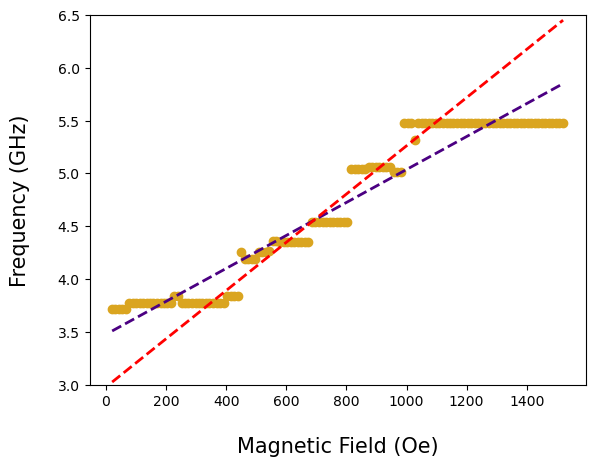

In [64]:
# Plotting scatter plot of lowest points
plt.scatter(Points["HDC"], Points["Freq"]/1e9, label='Scatter Plot', color='goldenrod')

# Generating best fit line and its equation
onlyHDC = (Points["HDC"])
onlyFreq = Points["Freq"]

FreqinGHz = onlyFreq/1e9

# Best fit line of all points
m, b = np.polyfit(onlyHDC, onlyFreq, 1) 
plt.plot(onlyHDC, ((m * onlyHDC) + b)/1e9, color='indigo', linestyle='--', linewidth=2)
Eq1 = 'Purple - All points: y = ' + '{:.2f}'.format(m) + 'x + ' + '{:.2f}'.format(b)

# Optimal Best fit line
m9, b9 = np.polyfit(onlyHDC[33:89], onlyFreq[33:89], 1)
plt.plot(onlyHDC, ((m9 * onlyHDC) + b9)/1e9, color='r', linestyle='--', linewidth=2)
Eq9 = 'Red - Optimal points: y = ' + '{:.2f}'.format(m9) + 'x + ' + '{:.2f}'.format(b9)


m = m9 #m   #adjust m9 and b9 to just m and b to use the overall best fit line for the modeling. M9 and B9 use the optimal best fit line (provided here) 
b = b9 #b   #which was determined by using the methodology in Sherburne et. al. 2024 ACS Omega reference.

plt.xlabel('Magnetic Field (Oe)', fontsize = 15, labelpad = 20)
plt.ylabel('Frequency (GHz)', fontsize = 15, labelpad = 20)
plt.ylim(3, 6.5)
plt.show()

3. Students retrieve coefficients from the outputted code. 

In [65]:
# Equations for alpha and Hint, using slope (m) and y-int (b) of best fit line
yom = m/1e6                               # in Oe
yo = 2.8                                  # in MHz/Oe - so everything else has to be MegaHz or Oe
finter = (b/(10**6))                      # in Hz, converting to MHz

alpha = math.sqrt(abs((yo/yom)-1))
Hint = (finter * (1 + (alpha**2)))/yo
print(alpha) #First value printed is the alpha coefficient value
print(Hint)  #Second value printed is the internal H-field value

0.4752971644531991
1303.2077175557272


4. Using the first principles, Landau-Lifshitz-Gilbert Equation, the student creates a graph of magnetic susceptibility and a graph of FFT power v. frequency. This is done by assigning their calculated coefficients (outputted by the code above) to the associated variables under the "User Inputs" section.

In [66]:
# Plotting slice values against frequency in MHz
FreqX = Freq/(10**6)
SliceCol = 85                                      ## Change this to get new column! ##
SliceValuesY = smd_S21Test[SliceCol]

#SliceCol = 4 means HDC = 54.2Oe
#SliceCol = 21 means HDC = 251.3Oe
#SliceCol = 60 means HDC = 708.9Oe
#SliceCol = 85 means HDC = 1003.9Oe

# Finding HDC value for SilceValues column
SliceIndex = (SliceCol + 1)                                      # this is the index. The HDC unit is the slice column, since both start from zero.
HDCSlice = OriPoints._get_value(SliceIndex, 'HDC')               # this is the actual HDC value at that index
HDCSlice_str = HDCSlice.astype(str)                              # converting HDCSlice to string so can put in title

In [67]:
HDCSlice_str  #Shows the HDC field slice value in Oe

np.str_('1003.9')

In [68]:
# Normalize - Set average as new 0 if have only positive values
if min(SliceValuesY) > 0:                                      # If minimum is greater than 0, all values are positive
    min_value = min(SliceValuesY)
    max_value = max(SliceValuesY)
    middle_value = (min_value + max_value)/2
    SliceValuesY = SliceValuesY - middle_value                 # Rewriting Slice_ValuesY variable - setting middle aray value to 0

    plt.plot(FreqX, SliceValuesY, color = 'royalblue')
    plt.title('Shifted Slice from VNA-FMR at ' + HDCSlice_str + ' Oe')
    plt.xlabel('Freq (MHz)', fontsize = 18, labelpad = 16)
    plt.ylabel('$\Delta S_{21}$', fontsize = 15, labelpad = 16) #Values of Colormap

Have both positive and negative numbers in array-great!


In [69]:
## Constants needed in both First Principles and Python

#Hint is defined above                 #Internal Magnetization of the Particle (Oe) - Lee's paper used num modeling to get Hint, did not use it in input
#num modeling to get Hint, did not use it in input
#alpha is defined above                #Alpha Dampening Factor
Hdc = HDCSlice                         #Applied DC Magnetic Field (Oe)
r = 20e-9/2                            #Nanoparticle Radius (m)
K1 = -1.36e4/11                        #1st Order Anisotropy Constant (J/m^3), (Lee 2021 paper has it divided by 2 for an average) divide by 11 for 20nm particles
                                       #Divide by 11 - referenced from Sherburne et al. 2024 ACS Omega paper
Aex = 13.2e-12                         #J/m Exchange Energy

In [90]:
#User Inputs
MsUser = 20                                       #Magnetization saturation (emu/g)
p = 5.18                                            #Density of material (g/cm**3)
pm = 0.00000518                                     #g/m**3 density of material
Ge = 2                                              #G-Factor usually 2   - lines up well if 1.45
fLow = 1e1                                          #Lower Frequency to Sweep To
fHigh = 10e9                                        #Upper Frequency to Sweep To
fStep = 10e3                                        #Frequency Step Size

#Constants
u0 = 1.256E-6                                       #Permeability of a Vacuum (H/m)

#Calculation/Preparation Steps
K = K1 
dia = r*2                                           #Nanoparticle Diameter (m)
V = (4/3)*math.pi*r**3                              #Volume of Nanoparticle (m**3)
Ms = ((MsUser)*(p)*1000)                            #Magnetization saturation:(A/m) or (emu/cm**3) -> J/Tm**3
Hk = ((2*K)/(Ms*u0))                                #Anisotropic Magnetization (T)
H0 = (Hint+Hdc)*79.577471546                        #Applied Magnetic Field (A/m)

#Derive Gamma from 1st Principles Using QED
echarge = -1.602e-19                                #Charge of an Electron (C)
me = 9.109837015e-31                                #Electron Rest Mass (kg)
hbar = 1.054571817e-34                              #Planck's Constant (Js)
beta = (abs(echarge)*hbar)/(2*me)                   #Bohr magnetron
gamma = ((Ge*beta)/hbar)/1E4                        #Hz/Oe
gamma = gamma/79.577471546                          #m/As
gamma = gamma/(2*math.pi)

f=np.arange(fLow,fHigh,fStep)                       #Frequency Sweep (Hz)
ximagFreq = f

#Susceptibility equations are in terms of Hz instead of w to simplify math
xx = (gamma*(H0+(1)*Hk)-1j*(alpha/1)*f)
Xxx = (((gamma*Ms)*xx)/((gamma*(H0+(1)*Hk)-1j*(alpha/1)*f)**2-f**2))/(4*math.pi)
yFFT = np.sqrt(np.abs(Xxx)**2)/max(np.sqrt(np.abs(Xxx)**2))*1

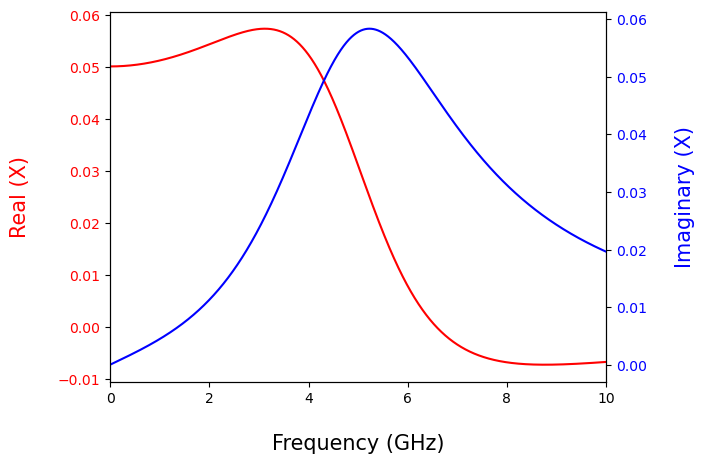

In [91]:
#Plotting

#Real and Imaginary
fig, ax1 = plt.subplots()
ax1.set_xlabel('Frequency (GHz)', fontsize = 15, labelpad = 20)
ax1.set_ylabel('Real (X)', color = 'red', fontsize = 15, labelpad = 20)
ax1.plot((f/1e9),np.real(Xxx), color = 'red')
ax1.tick_params(axis ='y', labelcolor = 'red')
ax2 = ax1.twinx()
ax2.set_ylabel('Imaginary (X)', color = 'blue', fontsize = 15, labelpad = 20)
ax2.plot((f/1e9),1*np.imag(Xxx), color = 'blue')
ax2.tick_params(axis ='y', labelcolor = 'blue')
plt.xlim((0,10))
plt.show()

5. Using Ubermag, the student will make a susceptibility graph. 

In [ ]:
## Ubermag

#Set Simulation Parameters
alphaUser = alpha
NumUnitCell = 1                                    #Number of Unit Cells Per Direction
UnitCell = (2*r)/NumUnitCell                       #Unit Cell Size (m) - at one time was 1.01e-08
MsUser = 20                                        #emu/g
gammaUser = (2.8e6/79.577)*2*np.pi                 #Hz/Oe -> m/As
Hac = 5*79.5774715459                              #A/m
pFe3O4 = 5.18

#Process Variables
Ms = MsUser*pFe3O4*1000                            #emu/g * g/cm^3 -> 1 emu/cm^3 -> 1000 A/m 
Hk = (2*K1)/(Ms*mm.consts.mu0)                     
Hstatic = (Hint+Hdc)*79.5774715459+Hk              #A/m 

UserCell = (UnitCell,UnitCell,UnitCell) # mesh discretisation (m)
def norm_fun(point):
    x, y, z = point
    if x**2 + y**2 + z**2 <= r**2:
        return Ms
    else:
         return 0

#Create Mesh
mesh = df.Mesh(p1=(-r, -r, -r), p2=(r, r, r), cell=UserCell)
m_init = df.Field(mesh=mesh, nvdim=3, value=(0, 0, 1), norm=norm_fun, valid = 'norm')
m_init.sel('x').mpl()
m_init.norm.k3d.nonzero()
system = mm.System(name='testfile2',T=0)       

#Ground State Energy Setup
system.energy = (mm.Exchange(A=Aex) +
mm.Demag() +
mm.CubicAnisotropy(K=K1, u1=(1, 0, 0), u2=(0, 1, 0)) +
mm.Zeeman(H=(0,0,Hstatic)))                         
system.energy
system.m = m_init
system.dynamics = mm.Precession(gamma0=gammaUser) + mm.Damping(alpha=alphaUser)
system.dynamics
md = mc.MinDriver()
md.drive(system)
system.m.sel('z').mpl()
system.energy += mm.Zeeman(H=(Hac,0,0), func='sinc', f=10e9, t0= 30e-9, name='ac')
td = mc.TimeDriver()
td.drive(system, t=100e-9, n=2000,n_threads = 20)
                                       #Frequency Peak of X''
                                     #Frequency Peak of X''

[]
[]


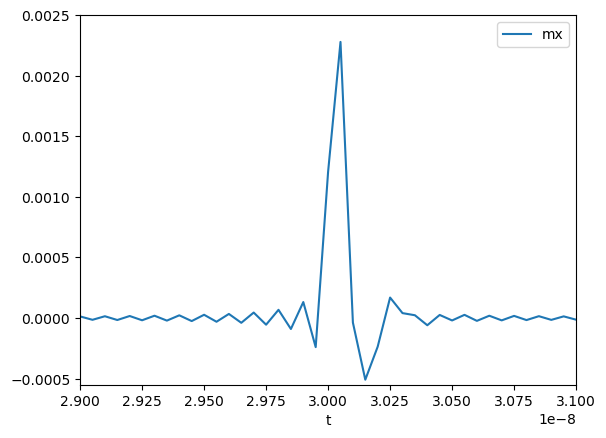

In [97]:
system.table.data.plot('t', 'mx')
plt.xlim((.29e-7,.31e-7))
plt.ylim((-0.00055,.0025))
fft = system.table.rfft()
susceptibility = (fft.data['ft_mx']*Ms)/((fft.data['ft_Bx_ac']/1e3)/(mm.consts.mu0))/(np.pi*4)
from scipy.signal import find_peaks
lst = -1*np.imag(susceptibility)
peaks, _ = find_peaks(lst, height=.1)
print(peaks)
freqpeak = np.array(fft.data['f'])
print(freqpeak[peaks])  

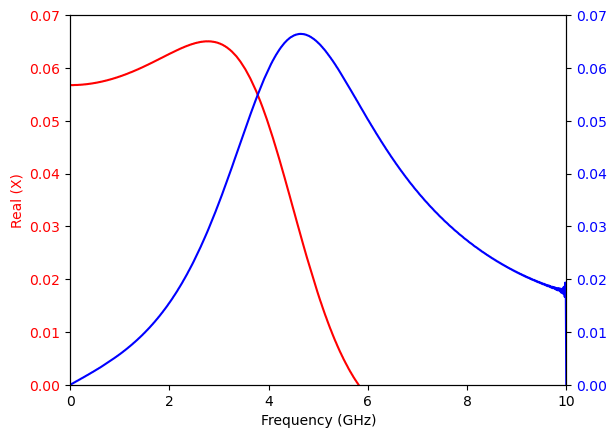

[]


In [100]:
# Creating Susceptibility Plot
fig, ax1 = plt.subplots()

ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('Real (X)', color = 'red')
ax1.plot((fft.data['f']/1e9),np.real(susceptibility), color = 'red')
plt.ylim((0,.07))
ax1.tick_params(axis ='y', labelcolor = 'red')
ax2 = ax1.twinx()


ax2.plot((fft.data['f']/1e9),-1*np.imag(susceptibility), color = 'blue')
ax2.tick_params(axis ='y', labelcolor = 'blue')
plt.xlim((0,10))
plt.ylim((0,.07))
plt.show()

print(freqpeak[peaks])    

6. Next, compare the VNA-FMR data (Step 2), First Principles Model (Step 4), and the Ubermag model (Step 5). Where is peak frequency? What is the shape of the resonance? How do the magnitudes of First Principles compare to those of the Ubermag code?

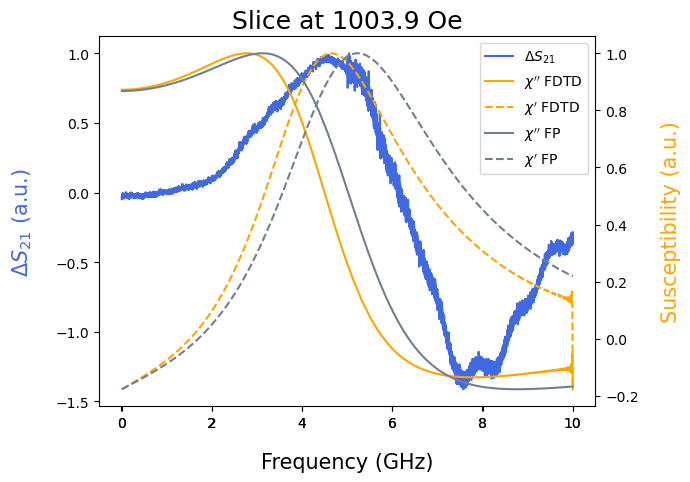

In [74]:
## Plotting Slice, 1st Principles, and Ubermag

# Get x and y data for each plot
SliceValues = -1 * SliceValuesY                                # flipping, great is have both pos and neg numbers, if don't, have to do new method
maxSlice = max(SliceValues)                                    # array is 10001 values long
comparableSlice = SliceValues/maxSlice

RealArray = np.real(susceptibility)
maxReal = max(RealArray)                                       # array is 1001 values long
comparableRealS = RealArray/maxReal

ImgArray = -1*np.imag(susceptibility)
maxImg = max(ImgArray)                                         # array is 1001 values long
comparableImgS = ImgArray/maxImg

RealArrayFP = np.real(Xxx)
maxRealFP = max(RealArrayFP)                                   # array is 1000,000 values long
comparableRealFP = RealArrayFP/maxRealFP

ImagArrayFP = 1*np.imag(Xxx)
maxImagFP = max(ImagArrayFP)                                   # array is 1000,000 values long
comparableImagFP = ImagArrayFP/maxImagFP

FreqGHz = Freq/(10**9)
OldFreq = (fft.data['f']/1e9)
FreqFP = f/1e9

# Plot together
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax3=fig.add_subplot(111, label="3", frame_on=False)
ax4=fig.add_subplot(111, label="4", frame_on=False)
ax5=fig.add_subplot(111, label="5", frame_on=False)

ax.plot(FreqGHz, comparableSlice, color="royalblue")
ax.set_ylabel("$\Delta S_{21}$ (a.u.)", color="royalblue", fontsize = 15, labelpad = 16)
ax.tick_params(axis='y', colors="black")

ax2.plot(OldFreq, comparableRealS, color="orange")
ax2.yaxis.tick_right()
ax2.set_xlabel("Frequency (GHz)", color="black", fontsize = 15, labelpad = 16)
ax2.set_ylabel('Susceptibility (a.u.)', color="orange", fontsize = 15, labelpad = 16)       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="black")
ax2.tick_params(axis='y', colors="black")

ax3.plot(OldFreq, comparableImgS, color="orange", linestyle = "dashed")
ax3.set_xticks([])
ax3.set_yticks([])

ax4.plot(FreqFP, comparableRealFP, color="slategrey")
ax4.set_xticks([])
ax4.set_yticks([])


ax5.plot(FreqFP, comparableImagFP, color="slategrey", linestyle = "dashed")
ax5.set_xticks([])
ax5.set_yticks([])

custom_lines = [Line2D([0], [0], color="royalblue"),
                Line2D([0], [0], color="orange"),
                Line2D([0], [0], color="orange", linestyle = "dashed"),
                Line2D([0], [0], color="slategrey"),
                Line2D([0], [0], color="slategrey", linestyle = "dashed")]

plt.legend(custom_lines, ["$\Delta S_{21}$", "$\chi''$ FDTD", "$\chi'$ FDTD", "$\chi''$ FP", "$\chi'$ FP"])
plt.title('Slice at ' + HDCSlice_str + ' Oe', fontsize = 18)
plt.show()

Teacher Tips: To save class time, have the students install ubermag on their electronic devices before class by following the provided procedure.

Follow up questions and responses: 
What are some differences you notice between the Ubermag, First Principles, and VNA-FMR data? What is the VNA-FMR data measuring? What is the region around 8GHz showing us? What does the slope of the best fit line for the VNA-FMR data represent? Why is the anisotropic coefficient K/11 and not K/2?